In [122]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random as rand
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error


In [123]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    df = df[['Longitude', 'Latitude']]
    # label_encoder = LabelEncoder()
    # for col in df.select_dtypes(include='object').columns:
    #     df[col] = label_encoder.fit_transform(df[col])
    # Rest of the code...
    filename = 'data_mmda_traffic_spatial.csv'
    df = df.dropna(axis='columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

In [124]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df[['Longitude', 'Latitude']]
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [125]:
nRowsRead = 1000 # specify 'None' if want to read whole file
# data_mmda_traffic_spatial.csv has 10989 rows in reality, but we are only loading/previewing the first 1000 rows
df1 = pd.read_csv('data_mmda_traffic_spatial.csv', delimiter=',', nrows = nRowsRead)
df1.dataframeName = 'data_mmda_traffic_spatial.csv'
nRow, nCol = df1.shape
print(f'There are {nRow} rows and {nCol} columns')

There are 1000 rows and 13 columns


In [126]:
df1.head(5)

,Date,Time,City,Location,Latitude,Longitude,High_Accuracy,Direction,Type,Lanes_Blocked,Involved,Tweet,Source
0,8/20/2018,7:55 AM,Pasig City,ORTIGAS EMERALD,14.586343,121.061481,1,EB,VEHICULAR ACCIDENT,1,TAXI AND MC,MMDA ALERT: Vehicular accident at Ortigas Emer...,https://twitter.com/mmda/status/10313302019705...
1,8/20/2018,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313462477459...
2,8/20/2018,9:13 AM,Makati City,EDSA ROCKWELL,14.559818,121.040737,1,SB,VEHICULAR ACCIDENT,1,SUV AND L300,MMDA ALERT: Vehicular accident at EDSA Rockwel...,https://twitter.com/mmda/status/10313589669896...
3,8/20/2018,8:42 AM,Mandaluyong,EDSA GUADIX,14.589432,121.057243,1,NB,STALLED L300 DUE TO MECHANICAL PROBLEM,1,L300,MMDA ALERT: Stalled L300 due to mechanical pro...,https://twitter.com/mmda/status/10313590696535...
4,8/20/2018,10:27 AM,San Juan,ORTIGAS CLUB FILIPINO,14.601846,121.046754,1,EB,VEHICULAR ACCIDENT,1,2 CARS,MMDA ALERT: Vehicular accident at Ortigas Club...,https://twitter.com/mmda/status/10313711248424...


In [127]:
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = int((nCol + nGraphPerRow - 1) / nGraphPerRow) # convert nGraphPerRow to an integer
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()


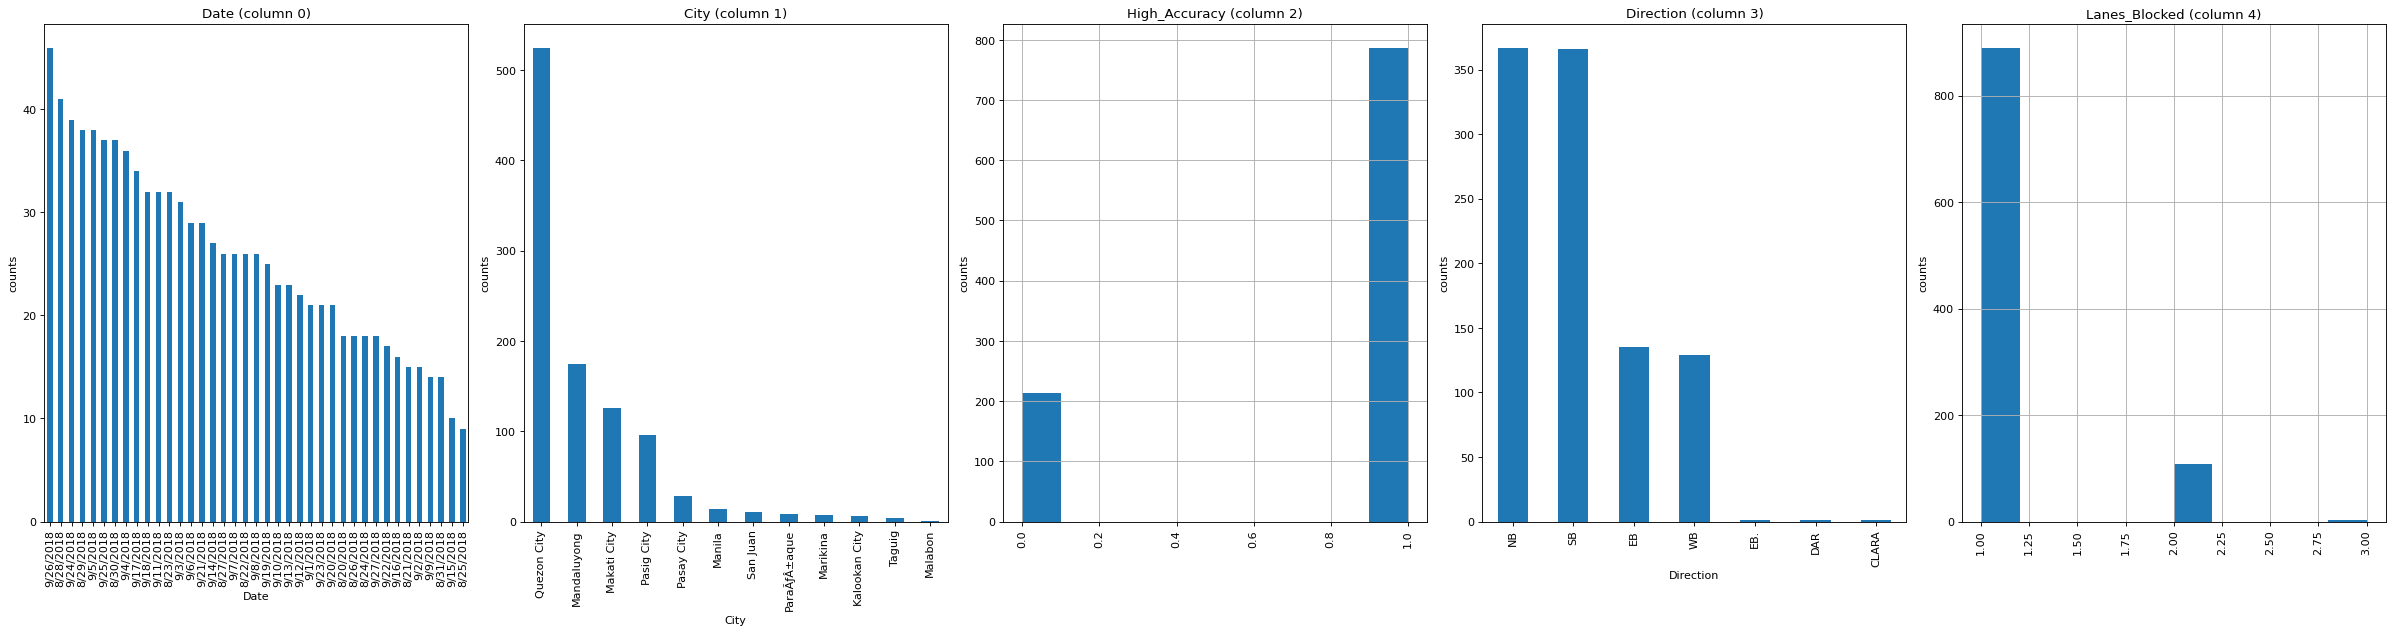

In [128]:
plotPerColumnDistribution(df1, 10, 5)

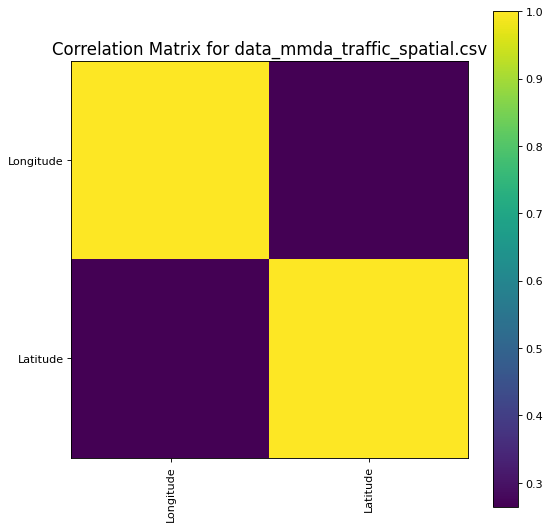

In [129]:
plotCorrelationMatrix(df1, 8)

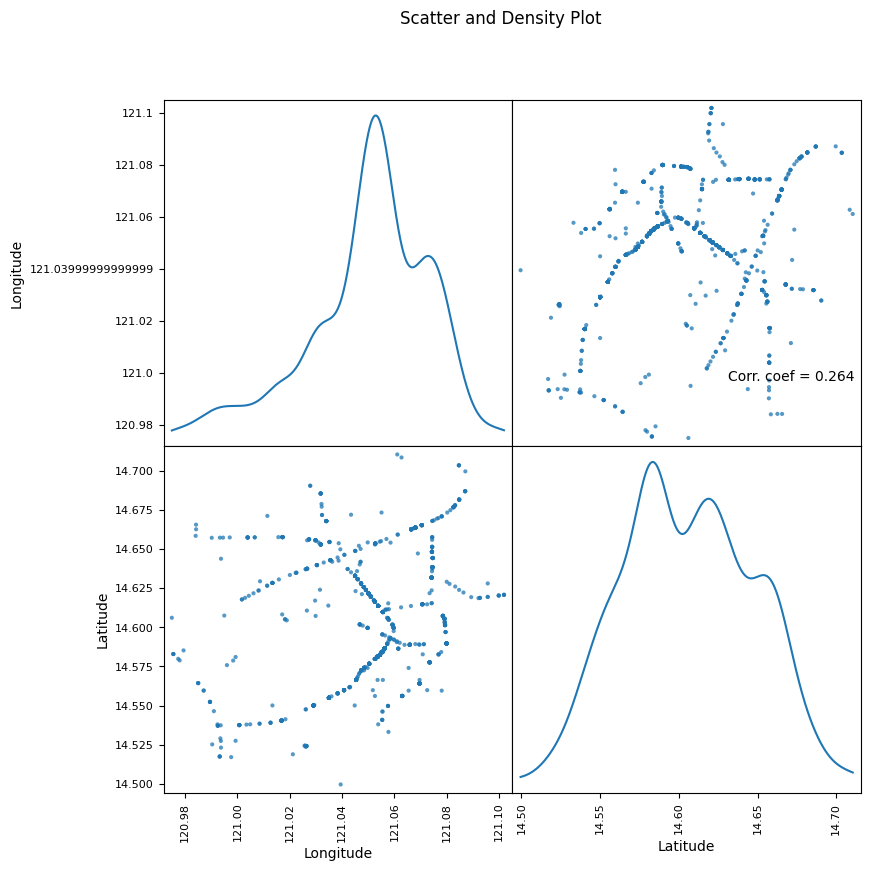

In [130]:
plotScatterMatrix(df1, 9, 10)

In [131]:
class RandomTrafficIncident:
    def __init__(self, csv):
        self.df = pd.read_csv(csv)
        
    def generate_event(self):
        Location = rand.choice(self.df['Location'])
        Longitude = rand.choice(self.df['Longitude'])
        Latitude = rand.choice(self.df['Latitude'])
        Time = rand.choice(self.df['Time'])
        
        return {'Direction': Direction, \
                'Location': Location, \
                'Latitude': Latitude, \
                'Longitude': Longitude, \
                'Time': Time}

In [132]:
csv = 'data_mmda_traffic_spatial.csv'
df = pd.read_csv(csv)
headers = df.columns.tolist()
rti = RandomTrafficIncident(csv)
df = rti.df
df.describe

<bound method NDFrame.describe of              Date      Time         City                      Location  \
0       8/20/2018   7:55 AM   Pasig City               ORTIGAS EMERALD   
1       8/20/2018   8:42 AM  Mandaluyong                   EDSA GUADIX   
2       8/20/2018   9:13 AM  Makati City                 EDSA ROCKWELL   
3       8/20/2018   8:42 AM  Mandaluyong                   EDSA GUADIX   
4       8/20/2018  10:27 AM     San Juan         ORTIGAS CLUB FILIPINO   
...           ...       ...          ...                           ...   
15309  12/27/2020  12:59 PM       Manila         QUIRINO GUAZON PETRON   
15310  12/27/2020   3:08 PM  Makati City                 EDSA ESTRELLA   
15311  12/27/2020   3:23 PM  Quezon City         EDSA P TUAZON FLYOVER   
15312  12/27/2020   7:46 PM  Quezon City         ORTIGAS AVE EDSA POEA   
15313  12/27/2020   9:39 PM       Manila  LEGARDA STA CATALINA COLLEGE   

        Latitude   Longitude  High_Accuracy Direction  \
0      14.586343  12

In [133]:
keys = { }
encoders = { }

In [134]:
X = df[['Longitude', 'Latitude']]
enc = LabelEncoder()
X_encoded = pd.DataFrame()

In [135]:
encoders['Longitude'] = LabelEncoder()
encoders['Latitude'] = LabelEncoder()
X_encoded['Longitude'] = encoders['Longitude'].fit_transform(X['Longitude'])
X_encoded['Latitude'] = encoders['Latitude'].fit_transform(X['Latitude'])

In [136]:
for item in X_encoded:
    keys[item] = { }
    for value in np.nditer(X_encoded[item]):
        value = value.tolist()
        temp = encoders[item].inverse_transform([value])[0]
        keys[item][temp] = value

for key in keys:
    print(keys[key])

{121.061481: 738, 121.057243: 675, 121.040737: 472, 121.046754: 545, 121.062936: 750, 121.058225: 693, 121.04841: 571, 121.050978: 595, 121.073462: 826, 121.07454: 869, 121.086405: 955, 120.993593: 127, 121.079945: 924, 121.047229: 555, 121.061261: 733, 121.078528: 901, 121.038708: 456, 121.092719: 981, 121.030335: 370, 121.029058: 357, 121.047259: 557, 121.052548: 617, 121.079351: 917, 121.070469: 794, 121.070339: 791, 121.049788: 587, 121.050365: 590, 121.040861: 474, 120.989491: 89, 121.070685: 798, 121.034967: 428, 121.035928: 438, 121.04307: 488, 121.079256: 914, 121.054467: 636, 120.987075: 76, 121.074217: 840, 121.062717: 745, 121.0744: 853, 121.079122: 912, 120.993705: 131, 121.05969: 714, 121.045356: 515, 121.039452: 463, 121.013365: 270, 121.055583: 652, 121.031852: 385, 121.069619: 790, 121.016837: 278, 120.994955: 148, 121.095678: 983, 121.074626: 874, 121.047569: 560, 121.053565: 630, 121.017212: 281, 121.05755: 678, 121.033972: 416, 121.092133: 977, 121.057809: 685, 121.0

In [137]:
y = df[['Time']]

In [138]:

X_encoded.head()
y_encoded = enc.fit_transform(y['Time'])
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.2, random_state=42)
model = RandomForestClassifier()
model.fit(X_train.astype(str), y_train)
y_pred = model.predict(X_test.astype(str))
print(X_encoded)

       Longitude  Latitude
0            738       269
1            675       301
2            472       130
3            675       301
4            545       380
...          ...       ...
15309        134       261
15310        472       130
15311        617       491
15312        692       324
15313        171       361

[15314 rows x 2 columns]


In [139]:
keys['Time'] = { }
for value in np.nditer(y_encoded):
    value = value.tolist()
    temp = enc.inverse_transform([value])[0]
    keys['Time'][value] = temp
keys['Time']

{1139: '7:55 AM',
 1240: '8:42 AM',
 1304: '9:13 AM',
 53: '10:27 AM',
 155: '11:18 AM',
 307: '12:33 PM',
 319: '12:39 PM',
 543: '2:51 PM',
 684: '4:14 PM',
 813: '5:17 PM',
 945: '6:21 PM',
 1065: '7:19 PM',
 1117: '7:44 PM',
 1274: '8:58 PM',
 1036: '7:05 AM',
 0: '10:00 AM',
 93: '10:47 AM',
 560: '3:03 PM',
 942: '6:20 AM',
 963: '6:30 AM',
 982: '6:39 AM',
 986: '6:41 AM',
 988: '6:42 AM',
 1000: '6:48 AM',
 1058: '7:16 AM',
 1066: '7:20 AM',
 1069: '7:21 AM',
 1082: '7:27 AM',
 1183: '8:15 AM',
 1225: '8:35 AM',
 1273: '8:58 AM',
 1275: '8:59 AM',
 1342: '9:32 AM',
 29: '10:15 AM',
 73: '10:37 AM',
 101: '10:51 AM',
 115: '10:58 AM',
 432: '1:40 PM',
 471: '2:05 PM',
 497: '2:21 PM',
 531: '2:43 PM',
 532: '2:44 PM',
 541: '2:50 PM',
 635: '3:47 PM',
 693: '4:18 PM',
 695: '4:19 PM',
 738: '4:40 PM',
 746: '4:44 PM',
 829: '5:24 PM',
 898: '5:58 PM',
 905: '6:02 PM',
 951: '6:24 PM',
 1168: '8:07 PM',
 814: '5:18 AM',
 1137: '7:54 AM',
 1169: '8:08 AM',
 1219: '8:32 AM',
 1246:

In [140]:
newData = {'Longitude': [121.07454, 121.053801], 'Latitude': [14.638481, 14.537979]}

for item in newData:
    temp = [ ]
    for value in newData[item]:
        temp.append(keys[item][value])
    newData[item] = temp

In [141]:
newData = pd.DataFrame(newData)
newData_encoded = pd.DataFrame()
print(newData)

   Longitude  Latitude
0        869       688
1        631        72


In [142]:
for feature in newData.columns:
    newData_encoded[feature] = encoders[feature].fit_transform(newData[feature])
enc_new_preds = model.predict(newData_encoded.astype(str))
new_preds = [ ]
for pred in enc_new_preds:
    new_preds.append(keys['Time'][pred])
print('New Predictions:', new_preds)

New Predictions: ['11:32 AM', '7:49 AM']
